In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.image as mpimg

class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # Set the width of the windows +/- margin
        self.window_margin = 56
        # x values of the fitted line over the last n iterations
        self.prevx = []
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        # starting x_value
        self.startx = None
        # ending x_value
        self.endx = None
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        # road information
        self.road_inf = None
        self.curvature = None
        self.deviation = None

def warp_image(img, src, dst, size):
    """ Perspective Transform """
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_img = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)

    return warp_img, M, Minv

def rad_of_curvature(left_line, right_line):
    """ measure radius of curvature  """

    ploty = left_line.ally
    leftx, rightx = left_line.allx, right_line.allx

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Define conversions in x and y from pixels space to meters
    width_lanes = abs(right_line.startx - left_line.startx)+1
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7*(720/1280) / width_lanes  # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    # radius of curvature result
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad

def smoothing(lines, pre_lines=3):
    # collect lines & print average line
    lines = np.squeeze(lines)
    avg_line = np.zeros((720))

    for ii, line in enumerate(reversed(lines)):
        if ii == pre_lines:
            break
        avg_line += line
    avg_line = avg_line / pre_lines

    return avg_line

def blind_search(b_img, left_line, right_line):
    """
    blind search - first frame, lost lane lines
    using histogram & sliding window
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(b_img[int(b_img.shape[0] / 2):, :], axis=0)

    # Create an output image to draw on and  visualize the result
    output = np.dstack((b_img, b_img, b_img)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    start_leftX = np.argmax(histogram[:midpoint])
    start_rightX = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    num_windows = 9
    # Set height of windows
    window_height = np.int(b_img.shape[0] / num_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = b_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    current_leftX = start_leftX
    current_rightX = start_rightX

    # Set minimum number of pixels found to recenter window
    min_num_pixel = 50

    # Create empty lists to receive left and right lane pixel indices
    win_left_lane = []
    win_right_lane = []

    window_margin = left_line.window_margin

    # Step through the windows one by one
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = b_img.shape[0] - (window + 1) * window_height
        win_y_high = b_img.shape[0] - window * window_height
        win_leftx_min = current_leftX - window_margin
        win_leftx_max = current_leftX + window_margin
        win_rightx_min = current_rightX - window_margin
        win_rightx_max = current_rightX + window_margin

        # Draw the windows on the visualization image
        cv2.rectangle(output, (win_leftx_min, win_y_low), (win_leftx_max, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(output, (win_rightx_min, win_y_low), (win_rightx_max, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        left_window_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_leftx_min) & (
            nonzerox <= win_leftx_max)).nonzero()[0]
        right_window_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_rightx_min) & (
            nonzerox <= win_rightx_max)).nonzero()[0]
        # Append these indices to the lists
        win_left_lane.append(left_window_inds)
        win_right_lane.append(right_window_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_window_inds) > min_num_pixel:
            current_leftX = np.int(np.mean(nonzerox[left_window_inds]))
        if len(right_window_inds) > min_num_pixel:
            current_rightX = np.int(np.mean(nonzerox[right_window_inds]))

    # Concatenate the arrays of indices
    win_left_lane = np.concatenate(win_left_lane)
    win_right_lane = np.concatenate(win_right_lane)

    # Extract left and right line pixel positions
    leftx, lefty = nonzerox[win_left_lane], nonzeroy[win_left_lane]
    rightx, righty = nonzerox[win_right_lane], nonzeroy[win_right_lane]

    output[lefty, leftx] = [255, 0, 0]
    output[righty, rightx] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, b_img.shape[0] - 1, b_img.shape[0])

    # ax^2 + bx + c
    left_plotx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_plotx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    left_line.prevx.append(left_plotx)
    right_line.prevx.append(right_plotx)

    if len(left_line.prevx) > 10:
        left_avg_line = smoothing(left_line.prevx, 10)
        left_avg_fit = np.polyfit(ploty, left_avg_line, 2)
        left_fit_plotx = left_avg_fit[0] * ploty ** 2 + left_avg_fit[1] * ploty + left_avg_fit[2]
        left_line.current_fit = left_avg_fit
        left_line.allx, left_line.ally = left_fit_plotx, ploty
    else:
        left_line.current_fit = left_fit
        left_line.allx, left_line.ally = left_plotx, ploty

    if len(right_line.prevx) > 10:
        right_avg_line = smoothing(right_line.prevx, 10)
        right_avg_fit = np.polyfit(ploty, right_avg_line, 2)
        right_fit_plotx = right_avg_fit[0] * ploty ** 2 + right_avg_fit[1] * ploty + right_avg_fit[2]
        right_line.current_fit = right_avg_fit
        right_line.allx, right_line.ally = right_fit_plotx, ploty
    else:
        right_line.current_fit = right_fit
        right_line.allx, right_line.ally = right_plotx, ploty

    left_line.startx, right_line.startx = left_line.allx[len(left_line.allx)-1], right_line.allx[len(right_line.allx)-1]
    left_line.endx, right_line.endx = left_line.allx[0], right_line.allx[0]

    left_line.detected, right_line.detected = True, True
    # print radius of curvature
    rad_of_curvature(left_line, right_line)
    return output

def prev_window_refer(b_img, left_line, right_line):
    """
    refer to previous window info - after detecting lane lines in previous frame
    """
    # Create an output image to draw on and  visualize the result
    output = np.dstack((b_img, b_img, b_img)) * 255

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = b_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    

    # Set margin of windows
    window_margin = left_line.window_margin

    #left_line_fit = left_line.current_fit
    #right_line_fit = right_line.current_fit
    
   # left_line_fit = np.polyfit(lefty[:,,:], leftx[:,:,], 2)
    #right_line_fit = np.polyfit(righty[:,,:], rightx[:,:,], 2)
    
    #leftx_min = left_line_fit[0] * nonzeroy ** 2 + left_line_fit[1] * nonzeroy + left_line_fit[2] - window_margin
    #leftx_max = left_line_fit[0] * nonzeroy ** 2 + left_line_fit[1] * nonzeroy + left_line_fit[2] + window_margin
    #rightx_min = right_line_fit[0] * nonzeroy ** 2 + right_line_fit[1] * nonzeroy + right_line_fit[2] - window_margin
    #rightx_max = right_line_fit[0] * nonzeroy ** 2 + right_line_fit[1] * nonzeroy + right_line_fit[2] + window_margin
    
    
    leftx_min = left_line.allx[-1] - window_margin
    leftx_max = left_line.allx[-1] + window_margin
    rightx_min = right_line.allx[-1] - window_margin
    rightx_max = right_line.allx[-1] + window_margin
    """
    lefty_min = left_line.ally[-1] - window_margin
    lefty_max = left_line.ally[-1] + window_margin
    righty_min = right_line.ally[-5] - window_margin
    righty_max = right_line.ally[-5] + window_margin
    
    &(nonzeroy >= lefty_min) & (nonzeroy <= lefty_max)
    & (nonzeroy >= righty_min) & (nonzeroy <= righty_max)
    """    
    # Identify the nonzero pixels in x and y within the window
    left_inds = ((nonzerox >= leftx_min) & (nonzerox <= leftx_max)).nonzero()[0]
    right_inds = ((nonzerox >= rightx_min) & (nonzerox <= rightx_max) ).nonzero()[0]

    #left_inds_y = ((nonzeroy >= lefty_min) & (nonzeroy <= lefty_max)).nonzero()[1]
    #right_inds_y = ((nonzeroy >= righty_min) & (nonzeroy <= righty_max)).nonzero()[1]
    
    #print(left_inds_x)
    
    # Extract left and right line pixel positions
    leftx, lefty = nonzerox[left_inds], nonzeroy[left_inds]
    rightx, righty = nonzerox[right_inds], nonzeroy[right_inds]
    """
    print(leftx)
    print(leftx)
    print(rightx)
    print(righty)
    """
    output[lefty, leftx] = [255, 0, 0]
    output[righty, rightx] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, b_img.shape[0] - 1, b_img.shape[0])

    # ax^2 + bx + c
    left_plotx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_plotx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    leftx_avg = np.average(left_plotx)
    rightx_avg = np.average(right_plotx)

    left_line.prevx.append(left_plotx)
    right_line.prevx.append(right_plotx)

    if len(left_line.prevx) > 10:
        left_avg_line = smoothing(left_line.prevx, 10)
        left_avg_fit = np.polyfit(ploty, left_avg_line, 2)
        left_fit_plotx = left_avg_fit[0] * ploty ** 2 + left_avg_fit[1] * ploty + left_avg_fit[2]
        left_line.current_fit = left_avg_fit
        left_line.allx, left_line.ally = left_fit_plotx, ploty
    else:
        left_line.current_fit = left_fit
        left_line.allx, left_line.ally = left_plotx, ploty

    if len(right_line.prevx) > 10:
        right_avg_line = smoothing(right_line.prevx, 10)
        right_avg_fit = np.polyfit(ploty, right_avg_line, 2)
        right_fit_plotx = right_avg_fit[0] * ploty ** 2 + right_avg_fit[1] * ploty + right_avg_fit[2]
        right_line.current_fit = right_avg_fit
        right_line.allx, right_line.ally = right_fit_plotx, ploty
    else:
        right_line.current_fit = right_fit
        right_line.allx, right_line.ally = right_plotx, ploty

    # goto blind_search if the standard value of lane lines is high.
    standard = np.std(right_line.allx - left_line.allx)

    if (standard > 80  ) :
        left_line.detected = False
    elif(standard < 30):
        left_line.detected = False
        
        
        

    left_line.startx, right_line.startx = left_line.allx[len(left_line.allx) - 1], right_line.allx[len(right_line.allx) - 1]
    left_line.endx, right_line.endx = left_line.allx[0], right_line.allx[0]

    # print radius of curvature
    rad_of_curvature(left_line, right_line)
    return output

def find_LR_lines(binary_img, left_line, right_line):
    """
    find left, right lines & isolate left, right lines
    blind search - first frame, lost lane lines
    previous window - after detecting lane lines in previous frame
    """

    # if don't have lane lines info
    if left_line.detected == False:
        return blind_search(binary_img, left_line, right_line)
    # if have lane lines info
    else:
        return prev_window_refer(binary_img, left_line, right_line)

def draw_lane(img, left_line, right_line, lane_color=(255, 0,255), road_color=(255, 255,50)):
    """ draw lane lines & current driving space """
    window_img = np.zeros_like(img)

    window_margin = left_line.window_margin
    left_plotx, right_plotx = left_line.allx, right_line.allx
    ploty = left_line.ally

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_pts_l = np.array([np.transpose(np.vstack([left_plotx - window_margin/5, ploty]))])
    left_pts_r = np.array([np.flipud(np.transpose(np.vstack([left_plotx + window_margin/5, ploty])))])
    left_pts = np.hstack((left_pts_l, left_pts_r))
    right_pts_l = np.array([np.transpose(np.vstack([right_plotx - window_margin/5, ploty]))])
    right_pts_r = np.array([np.flipud(np.transpose(np.vstack([right_plotx + window_margin/5, ploty])))])
    right_pts = np.hstack((right_pts_l, right_pts_r))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_pts]), lane_color)
    cv2.fillPoly(window_img, np.int_([right_pts]), lane_color)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_plotx+window_margin/5, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_plotx-window_margin/5, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), road_color)
    result = cv2.addWeighted(img, 1, window_img, 0.3, 0)

    return result, window_img

def road_info(left_line, right_line):
    """ print road information onto result image """
    curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2

    direction = ((left_line.endx - left_line.startx) + (right_line.endx - right_line.startx)) / 2

    if curvature > 2000 and abs(direction) < 100:
        road_inf = 'No Curve'
        curvature = -1
    elif curvature <= 2000 and direction < - 50:
        road_inf = 'Left Curve'
    elif curvature <= 2000 and direction > 50:
        road_inf = 'Right Curve'
    else:
        if left_line.road_inf != None:
            road_inf = left_line.road_inf
            curvature = left_line.curvature
        else:
            road_inf = 'None'
            curvature = curvature

    center_lane = (right_line.startx + left_line.startx) / 2
    lane_width = abs(right_line.startx - left_line.startx)+1

    center_car = 720 / 2
    if center_lane > center_car:
        deviation = 'Left ' + str(round(abs(center_lane - center_car)/(lane_width / 2)*100, 3)) + '%'
    elif center_lane < center_car:
        deviation = 'Right ' + str(round(abs(center_lane - center_car)/(lane_width / 2)*100, 3)) + '%'
    else:
        deviation = 'Center'
    left_line.road_inf = road_inf
    left_line.curvature = curvature
    left_line.deviation = deviation

    return road_inf, curvature, deviation

def print_road_status(img, left_line, right_line):
    """ print road status (curve direction, radius of curvature, deviation) """
    road_inf, curvature, deviation = road_info(left_line, right_line)
    cv2.putText(img, 'Road Status', (22, 30), cv2.FONT_HERSHEY_COMPLEX, 0.7, (80, 80, 80), 2)

    lane_inf = 'Lane Info : ' + road_inf
    if curvature == -1:
        lane_curve = 'Curvature : Straight line'
    else:
        lane_curve = 'Curvature : {0:0.3f}m'.format(curvature)
    deviate = 'Deviation : ' + deviation

    cv2.putText(img, lane_inf, (10, 63), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 100, 100), 1)
    cv2.putText(img, lane_curve, (10, 83), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 100, 100), 1)
    cv2.putText(img, deviate, (10, 103), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 100, 100), 1)

    return img



In [2]:
import numpy as np
import cv2

def sobel_xy(img, orient='x', thresh=(20, 100)):
    """
    Define a function that applies Sobel x or y.
    The gradient in the x-direction emphasizes edges closer to vertical.
    The gradient in the y-direction emphasizes edges closer to horizontal.
    """
    # img = exposure.equalize_hist(img)
    # adaptive histogram equalization
    # img = exposure.equalize_adapthist(img, clip_limit=0.01)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Define a function to return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """

    # adaptive histogram equalization
    # img = exposure.equalize_adapthist(img, clip_limit=0.01)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 255

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    """
    computes the direction of the gradient
    """
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255
    # Return the binary image
    return binary_output.astype(np.uint8)

def ch_thresh(ch, thresh=(80, 255)):
    binary = np.zeros_like(ch)
    binary[(ch > thresh[0]) & (ch <= thresh[1])] = 255
    return binary

def gradient_combine(img, th_x, th_y, th_mag, th_dir):
    """
    Find lane lines with gradient information of Red channel
    """
    rows, cols = img.shape[:2]
    R = img[220:rows - 12, 0:cols, 2]

    sobelx = sobel_xy(R, 'x', th_x)
    #cv2.imshow('sobel_x', sobelx)
    sobely = sobel_xy(R, 'y', th_y)
    #cv2.imshow('sobel_y', sobely)
    mag_img = mag_thresh(R, 3, th_mag)
    #cv2.imshow('sobel_mag', mag_img)
    dir_img = dir_thresh(R, 15, th_dir)
    #cv2.imshow('result5', dir_img)

    # combine gradient measurements
    gradient_comb = np.zeros_like(dir_img).astype(np.uint8)
    gradient_comb[((sobelx > 1) & (mag_img > 1) & (dir_img > 1)) | ((sobelx > 1) & (sobely > 1))] = 255

    return gradient_comb

def hls_combine(img, th_h, th_l, th_s):
    # convert to hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    rows, cols = img.shape[:2]
    R = img[220:rows - 12, 0:cols, 2]
    _, R = cv2.threshold(R, 180, 255, cv2.THRESH_BINARY)
    #cv2.imshow('red!!!',R)
    H = hls[220:rows - 12, 0:cols, 0]
    L = hls[220:rows - 12, 0:cols, 1]
    S = hls[220:rows - 12, 0:cols, 2]

    h_img = ch_thresh(H, th_h)
    #cv2.imshow('HLS (H) threshold', h_img)
    l_img = ch_thresh(L, th_l)
    #cv2.imshow('HLS (L) threshold', l_img)
    s_img = ch_thresh(S, th_s)
    #cv2.imshow('HLS (S) threshold', s_img)

    # Two cases - lane lines in shadow or not
    hls_comb = np.zeros_like(s_img).astype(np.uint8)
    hls_comb[((s_img > 1) & (l_img == 0)) | ((s_img == 0) & (h_img > 1) & (l_img > 1))] = 255 # | (R > 1)] = 255
    #hls_comb[((s_img > 1) & (h_img > 1)) | (R > 1)] = 255
    return hls_comb

def comb_result(grad, hls):
    """ give different value to distinguish them """
    result = np.zeros_like(hls).astype(np.uint8)
    #result[((grad > 1) | (hls > 1))] = 255
    result[(grad > 1)] = 100
    result[(hls > 1)] = 255

    return result


In [3]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Array to store object points and image points from all the images

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

def calib():
    """
    To get an undistorted image, we need camera matrix & distortion coefficient
    Calculate them with 9*6 20 chessboard images
    """
    # Prepare object points
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)  # x,y coordinates

    for fname in images:

        img = mpimg.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            continue

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist

def undistort(img, mtx, dist):
    """ undistort image """
    return cv2.undistort(img, mtx, dist, None, mtx)

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import exposure
input_type = 'video' #'video' # 'image'
input_name = 'harder_challenge_video.mp4' #'test_images/straight_lines1.jpg' # 'challenge_video.mp4'
final=[]
left_line = Line()
right_line = Line()

th_sobelx, th_sobely, th_mag, th_dir = (35, 100), (30, 255), (30, 255), (0.7, 1.3)
th_h, th_l, th_s = (10, 100), (0, 60), (85, 255)

# camera matrix & distortion coefficient
mtx, dist = calib()

if __name__ == '__main__':
    input_type == 'video'
    cap = cv2.VideoCapture(input_name)
    while (True):
        success, frame = cap.read()
        if(success):

             # Correcting for Distortion
            undist_img = undistort(frame, mtx, dist)
                # resize video
            undist_img = cv2.resize(undist_img, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
            rows, cols = undist_img.shape[:2]

            combined_gradient = gradient_combine(undist_img, th_sobelx, th_sobely, th_mag, th_dir)
                #cv2.imshow('gradient combined image', combined_gradient)

            combined_hls = hls_combine(undist_img, th_h, th_l, th_s)
                #cv2.imshow('HLS combined image', combined_hls)

            combined_result = comb_result(combined_gradient, combined_hls)

            c_rows, c_cols = combined_result.shape[:2]
            s_LTop2, s_RTop2 = [c_cols / 2 - 24, 5], [c_cols / 2 + 24, 5]
            s_LBot2, s_RBot2 = [110, c_rows], [c_cols - 110, c_rows]

            src = np.float32([s_LBot2, s_LTop2, s_RTop2, s_RBot2])
            dst = np.float32([(170, 720), (170, 0), (550, 0), (550, 720)])

            warp_img, M, Minv = warp_image(combined_result, src, dst, (720, 720))
            #cv2.imshow('warp', warp_img)



            searching_img = find_LR_lines(warp_img, left_line, right_line)
            #cv2.imshow('LR searching', searching_img)

            w_comb_result, w_color_result = draw_lane(searching_img, left_line, right_line)
            #cv2.imshow('w_comb_result', w_comb_result)

                # Drawing the lines back down onto the road
            color_result = cv2.warpPerspective(w_color_result, Minv, (c_cols, c_rows))
            lane_color = np.zeros_like(undist_img)
            lane_color[220:rows - 12, 0:cols] = color_result

                # Combine the result with the original image
            result = cv2.addWeighted(undist_img, 1, lane_color, 0.3, 0)
                #cv2.imshow('result', result.astype(np.uint8))

            info =  np.zeros_like(result)
            info[5:110, 5:190] = (255, 255, 255)

            info = cv2.addWeighted(result, 1, info, 0.2, 0)


            info = print_road_status(info, left_line, right_line)
            cv2.imshow('road info', info)

            #out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            if cv2.waitKey(1) & 0xFF == ord('s'):
                cv2.waitKey(0)

            final.append(info)   
        else:
            break
    cap.release()
    cv2.destroyAllWindows()



C:\Users\Abdo\AppData\Local\Temp\ipykernel_6572\713389056.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
C:\Users\Abdo\AppData\Local\Temp\ipykernel_6572\713389056.py:102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release n

In [5]:
len(final)

1199

In [6]:
def write_image(path, img):
    # img = img*(2**16-1)
    # img = img.astype(np.uint16)
    # img = img.astype(np.uint8)
    img = cv2.convertScaleAbs(img, alpha=(255.0))
    cv2.imwrite(path, img)

In [7]:
import os
if not os.path.exists("data5"):
    os.makedirs('data5')
for i in range(len(final)):
    name = './data5/frame'+ ""+str(i)+ '.jpg'
    cv2.imwrite(name,final[i])

In [14]:
import cv2
import numpy as np
import glob

img_array = []
i = 0
#for filename in glob.glob("data5/frame"+ ""+str(i)+".jpg"):
for i in range(len(final)):
    img = cv2.imread("data5/frame"+ ""+str(i)+".jpg")
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 25 , size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [9]:
def img_show(img , title, cmap_type="gray" ):
    plt.figure(figsize=(13,13))
    plt.title(title)
    plt.imshow(img,cmap_type)

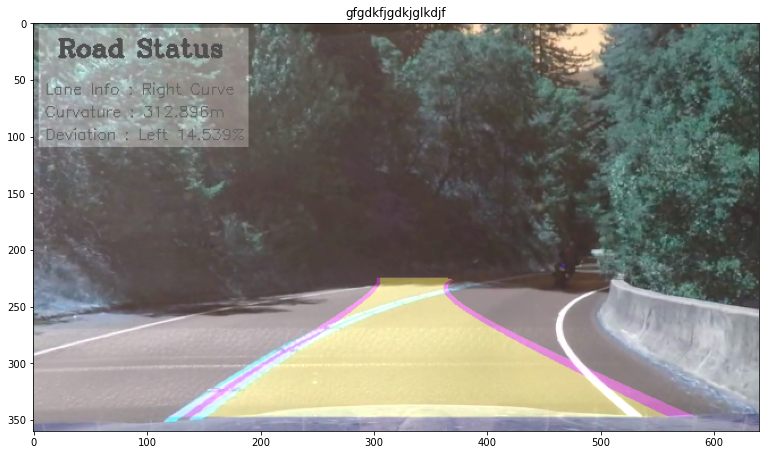

In [10]:
img_show(final[148] ,"gfgdkfjgdkjglkdjf" )